# Download some requirements

Import necessary libraries

In [1]:
! pip install celluloid
! pip install ffmpeg
from celluloid import Camera
from matplotlib.animation import FFMpegWriter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from tqdm.notebook import tqdm


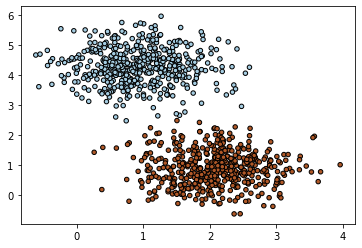

In [2]:
X, Y = make_blobs(n_samples=1000, centers=2, random_state=0, cluster_std=0.60)
Y[Y==0] = -1  # change labels from 0,1 to -1,1
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired,
            edgecolor='black', s=20)
plt.show()


In [3]:
np.random.seed(42)

In [4]:
def getBatch(X,Y,batch_size):
  batch_indxs = np.random.choice(len(X), size=batch_size, replace=False)
  X_batch = X[batch_indxs]
  Y_batch = Y[batch_indxs]
  return X_batch, Y_batch

def predict(x,H_params):
  W,b = H_params
  return (np.dot(W.transpose(), x) + b)

def plotHyperPlane(ax,H_params, t=None,lr_t=None):
  # plot the line, the points, and the nearest vectors to the plane
  x1min, x2min = np.min(X, axis=0)
  x1max, x2max = np.max(X, axis=0)
  xx = np.linspace(x1min, x1max, 10)
  yy = np.linspace(x2min, x2max, 10)

  X1, X2 = np.meshgrid(xx, yy)
  Z = np.empty(X1.shape)
  for (i, j), val in np.ndenumerate(X1):
      x1 = val
      x2 = X2[i, j]
      p = predict([[x1], [x2]], H_params)
      Z[i, j] = p[0]
  levels = [-1.0, 0.0, 1.0]
  linestyles = ['dashed', 'solid', 'dashed']
  colors = 'k'
  ax.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
  ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired,
              edgecolor='black', s=20)
  #ax.set_title(("(%.3f)x1+(%.3f)x2+(%.3f)=0")%(H_params[0][0],H_params[0][1],H_params[1]))
  if t is None:
    ax.text(0,1.01,("(%.3f)x1+(%.3f)x2+(%.3f)=0")%(H_params[0][0],H_params[0][1],H_params[1]), fontsize=7,transform=ax.transAxes)
  else:
    ax.text(0,1.01,("t=%d, H=(%.3f)x1+(%.3f)x2+(%.3f)=0, lr=%.1E")%(t,H_params[0][0],H_params[0][1],H_params[1],lr_t), fontsize=7,transform=ax.transAxes)


In [5]:
def SGD(X,Y,H_params,C,lr,n_iter, batch_size=50, loss="hinge", ax=None,camera=None,plot=False):
  W,b = H_params
  lr_diff = lr[1]-lr[0]

  if plot:
    plotHyperPlane(ax,H_params, t=0,lr_t=lr[0])
    camera.snap()

  for t in tqdm(range(n_iter), leave=False):
    lr_t = (lr_diff/(n_iter-1))*t + lr[0]   # linear
    X_batch, Y_batch = getBatch(X,Y,batch_size)
    delI_by_delW = np.zeros(W.shape)
    delI_by_delb = 0
    # sum the hinge loss gradients by looping over each sample
    for x,y in zip(X_batch,Y_batch):
      output = y*(np.dot(W.transpose(), x) + b)
      if loss in ["hinge", "sq_hinge"]:
        if output < 1:
          if loss == "hinge":
            delI_by_delW += -y*np.transpose([x])
            delI_by_delb += -y
          elif loss == "sq_hinge":  # use smaller value of C for squared hinge loss
            delI_by_delW += 2*(1-output)*(-y*np.transpose([x]))
            delI_by_delb += 2*(1-output)*(-y)
      elif loss == "logistic":
        delI_by_delW += (-np.exp(output)/(1+np.exp(output)))*(-y*np.transpose([x]))
        delI_by_delb += (-np.exp(output)/(1+np.exp(output)))*(-y)

    delI_by_delW = delI_by_delW*len(X)/batch_size
    delI_by_delb = delI_by_delb*len(X)/batch_size

    delf_by_delW = W + C*delI_by_delW
    delf_by_delb = C*delI_by_delb

    W = W - lr_t*delf_by_delW
    b = b - lr_t*delf_by_delb

    if plot:
      plotHyperPlane(ax,(W,b), t=t,lr_t=lr_t)
      camera.snap()

  return W,b


  0%|          | 0/200 [00:00<?, ?it/s]

(array([[-0.64132033],
       [ 2.61019729]]), array([-5.84332832]))


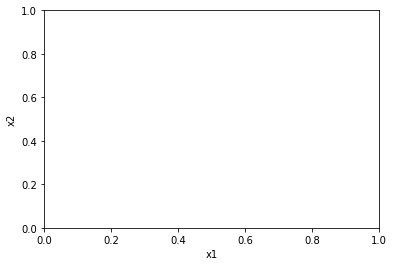

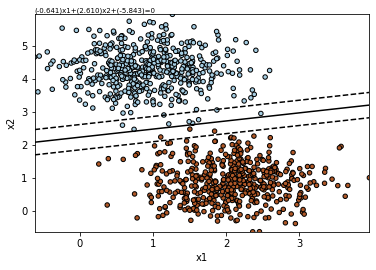

In [6]:
W = np.random.rand(2,1)
b = np.random.rand()
H_params = W,b

fig, ax = plt.subplots()
ax.set_xlabel("x1");  ax.set_ylabel("x2")
camera = Camera(fig)

H_params = SGD(X,Y,H_params, C=0.1, lr=[1e-1,1e-3], loss="logistic", n_iter=200, ax=ax,camera=camera, plot=False)
fig, ax = plt.subplots()
ax.set_xlabel("x1");  ax.set_ylabel("x2")
plotHyperPlane(ax,H_params)
print(H_params)


In [ ]:
animation = camera.animate()
animation.save("svm.gif",fps=10)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.


  0%|          | 0/200 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.


  0%|          | 0/200 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.


  0%|          | 0/200 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.


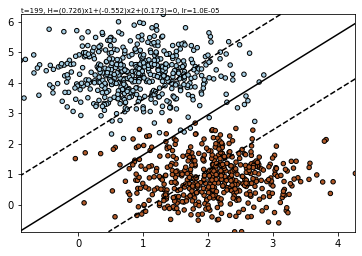

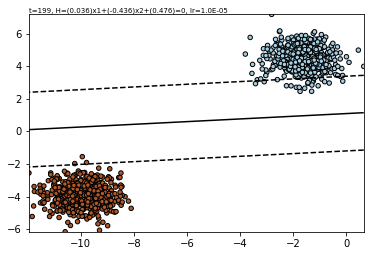

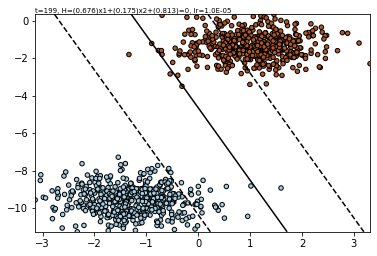

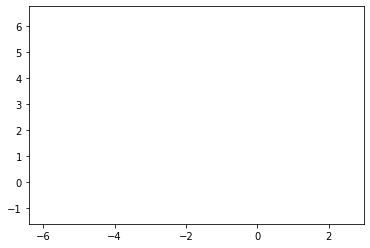

In [8]:
n_tests=4
for i in tqdm(range(n_tests)):
  X, Y = make_blobs(n_samples=1000, centers=2, random_state=i, cluster_std=0.70)
  Y[Y==0] = -1  # change labels from 0,1 to -1,1

  W = np.random.rand(2,1)
  b = np.random.rand()
  H_params = W,b

  fig, ax = plt.subplots()
  # ax.set_xlabel("x1");  ax.set_ylabel("x2")
  camera = Camera(fig)

  H_params = SGD(X,Y,H_params, C=0.006, lr=[5e-3,1e-5], n_iter=200, ax=ax,camera=camera, plot=True)
  animation = camera.animate()
  animation.save(("svm%d.gif")%(i),fps=10)
